# Exercise 4. Convolutional networks

## Learning goals

The goal of this exercise:
* to get familiar with convolutional neural networks used for image classification tasks
* to get familiar with the modern architectures of the convolutional networks: VGG-style and ResNet

You may find it useful to look at this tutorial:
* [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

## Part 1. Simple convolutional network

In [30]:
skip_training = True  # Set this flag to True before validation and submission

In [3]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [4]:
# Select data directory
import os
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    # course_data_dir = ...
    # YOUR CODE HERE
    raise NotImplementedError()

print('The data directory is %s' % course_data_dir)

The data directory is /coursedata


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [7]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## FashionMNIST dataset

Let us use the FashionMNIST dataset. It consists of 60,000 training images of 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Min-max scaling to [-1, 1]
])

data_dir = os.path.join(course_data_dir, 'fashion_mnist')
print('Data stored in %s' % data_dir)
trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Data stored in /coursedata/fashion_mnist


Let us visualize the data.

In [9]:
def plot_images(images, n_rows=1):
    fig, axs = plt.subplots(n_rows, images.size(0) // n_rows)
    for ax, img in zip(axs.flat, images):
        ax.matshow(img[0].cpu().numpy(), cmap=plt.cm.Greys)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tight_layout(w_pad=0)

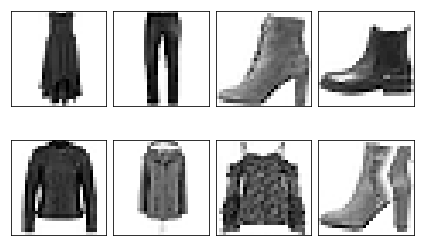

In [10]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
plot_images(images[:8], n_rows=2)

# 1. Simple convolutional network

In the first exercise, your task is to create a convolutional neural network with the architecture inspired by the classical [Le-Net 5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf):

<img src="simple_net.png" width=350 style="float: left;">

The architecture of the convolutional network that you need to create:
* 2d convolutional layer with:
    * one input channel
    * 16 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* 2d convolutional layer with:
    * 32 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* A fully-connected layer with:
    * 120 outputs
    * followed by ReLU
* A fully-connected layer with:
    * 84 outputs
    * followed by ReLU
* A fully-connected layer with 10 outputs and without nonlinearity.

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # YOUR CODE HERE
        self.conv1=nn.Conv2d(1,16,5)
        self.conv2=nn.Conv2d(16,32,5)
        self.fc1=nn.Linear(32*4*4,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
        #raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        x=F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2,stride=2)
        x=F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2,stride=2)
        x=x.reshape(x.size(0),-1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
        #raise NotImplementedError()

In [19]:
# Let's test the shapes of the tensors
# Create a network
net = Net()
net.to(device)

# Feed a batch of images from the training data to test the network
with torch.no_grad():
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    images = images.to(device)
    print('Shape of the input tensor:', images.shape)

    y = net(images)
    assert y.shape == torch.Size([32, 10]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')

Shape of the input tensor: torch.Size([32, 1, 28, 28])
The shapes seem to be ok.


In [20]:
# This is a cell used for grading

In [21]:
# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [22]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [23]:
n_epochs = 10

In [24]:
# Let us train the network for 10 epochs (one epoch is one pass though the training data)
# The loss should go down during training
net.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    print_every = 200  # mini-batches
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Transfer to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
        if skip_training:
            break

    # Print accuracy after every epoch
    accuracy = compute_accuracy(net, testloader)
    print('Accuracy of the network on the test images: %.3f' % accuracy)

    if skip_training:
        break

print('Finished Training')

[1,   200] loss: 2.296
[1,   400] loss: 2.268
[1,   600] loss: 1.997
[1,   800] loss: 1.157
[1,  1000] loss: 0.891
[1,  1200] loss: 0.780
[1,  1400] loss: 0.744
[1,  1600] loss: 0.704
[1,  1800] loss: 0.666
Accuracy of the network on the test images: 0.731
[2,   200] loss: 0.641
[2,   400] loss: 0.642
[2,   600] loss: 0.596
[2,   800] loss: 0.609
[2,  1000] loss: 0.594
[2,  1200] loss: 0.575
[2,  1400] loss: 0.561
[2,  1600] loss: 0.562
[2,  1800] loss: 0.524
Accuracy of the network on the test images: 0.779
[3,   200] loss: 0.509
[3,   400] loss: 0.519
[3,   600] loss: 0.494
[3,   800] loss: 0.505
[3,  1000] loss: 0.504
[3,  1200] loss: 0.506
[3,  1400] loss: 0.483
[3,  1600] loss: 0.452
[3,  1800] loss: 0.482
Accuracy of the network on the test images: 0.833
[4,   200] loss: 0.427
[4,   400] loss: 0.454
[4,   600] loss: 0.434
[4,   800] loss: 0.448
[4,  1000] loss: 0.439
[4,  1200] loss: 0.442
[4,  1400] loss: 0.431
[4,  1600] loss: 0.417
[4,  1800] loss: 0.413
Accuracy of the networ

In [25]:
# Save the network to a file, submit this file together with your notebook
filename = '4_simple_conv_net.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(net.state_dict(), filename)
            print('Model saved to %s' % filename)
        else:
            print('Model not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    net = Net()
    net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    net.to(device)
    print('Model loaded from %s' % filename)

Do you want to save the model (type yes to confirm)? yes
Model saved to 4_simple_conv_net.pth


Ground truth labels:  Ankle boot   Pullover    Trouser    Trouser      Shirt
Predictions:          Ankle boot   Pullover    Trouser    Trouser      Shirt


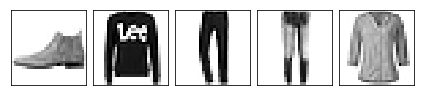

In [26]:
# Let us display random images from the test set, the ground truth labels and the network's predictions
net.eval()
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    plot_images(images[:5], n_rows=1)
    
    # Compute predictions
    images = images.to(device)
    y = net(images)

print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:         ', ' '.join('%10s' % classes[j] for j in y.argmax(dim=1)))

Let us now compute the accuracy of the network on the test set.

In [27]:
# Let us compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)

Accuracy of the network on the test images: 0.883


In [28]:
# Let us look at the confusion matrix computed for the test set
import sklearn.metrics as skmetrics

def confusion_matrix(net, testloader):
    net.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.argmax(outputs.data, 1)
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    true_labels = np.hstack(true_labels)
    predictions = np.hstack(predictions)

    return skmetrics.confusion_matrix(true_labels, predictions)

Text(33,0.5,'true labels')

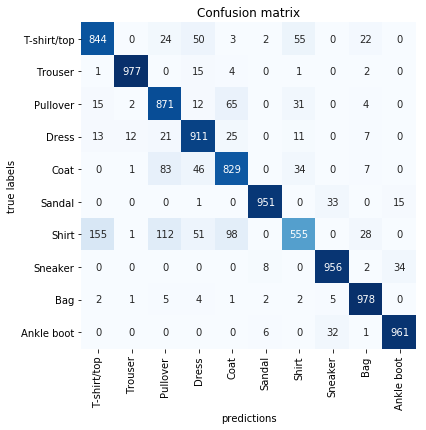

In [29]:
import seaborn as sns

c_matrix = confusion_matrix(net, testloader)
plt.figure(figsize=(6, 6))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=False)
plt.xlabel('predictions')
plt.ylabel('true labels')

Note which classes get confused most often.